In [1]:
import sys
sys.path.insert(0, "D:\Programming\extedned_peer_selection\peerselect")
sys.path.insert(0, "/home/szhydkov/Documents/mattei peer review/extedned_peer_selection/peerselect")

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [71]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from collections import Counter

# from importlib import reload

from peerselect import impartial
from peerselect import profile_generator
# reload(peerselect)

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 25}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10)
#np.set_printoptions(threshold=np.inf)

In [5]:
# Allows to use Julia within Python
# Steps if you want to make it work:
# 1. Install Julia from https://julialang.org/downloads/
# 2. Install pyjulia:
#    $ python3 -m pip install julia
# Takes a few seconds to run the first time
import julia
julia.Julia(compiled_modules=False)
from julia import Main
Main.include("funs.jl")

<PyCall.jlwrap estimate_eps>

In [6]:
# Example usage of a function from funs.jl
# estimate_eps(n, m, k) returns the epsilon that should give the right expected size.
Main.estimate_eps(120, 9, 30)

0.1423911244719702

In [7]:
class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

## Testing new features 

In [74]:
n = 120
k = 20
m = 7
l = 2
p = 0.1

agents = np.arange(0, n)
profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [p, 1-p], [agents, agents[::-1]], [0.8, 0.8])
clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)

# Borda -- need to start at 1 to distinguish from non-review in the score matrix
scores = np.arange(m, 0, -1)

# Approval a-la PeerNomination
nom_quota = (k/n)*m
scores_pn = np.concatenate((np.ones(math.floor(nom_quota)),
        [nom_quota-math.floor(nom_quota)],
        np.zeros(m-math.ceil(nom_quota))))

# Generate an m-regular assignment
m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)

score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

In [75]:
impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)

IndexError: list index out of range

Agent  0
Errors:  2.0
Steps:  [0.094 0.188]

Agent  0
Errors:  2.0
Steps:  [0.094 0.188]

Agent  1
Errors:  1.0
Steps:  [0.094 0.188]

Agent  1
Errors:  1.0
Steps:  [0.094 0.188]

Agent  2
Errors:  5.0
Steps:  [0.094 0.188]

Agent  2
Errors:  5.0
Steps:  [0.094 0.188]

Agent  3
Errors:  1.0
Steps:  [0.094 0.188]

Agent  3
Errors:  1.0
Steps:  [0.094 0.188]

Agent  4
Errors:  2.0
Steps:  [0.094 0.188]

Agent  4
Errors:  2.0
Steps:  [0.094 0.188]

Agent  5
Errors:  2.0
Steps:  [0.094 0.188]

Agent  5
Errors:  2.0
Steps:  [0.094 0.188]

Agent  6
Errors:  2.0
Steps:  [0.094 0.188]

Agent  6
Errors:  2.0
Steps:  [0.094 0.188]

Agent  7
Errors:  2.0
Steps:  [0.094 0.188]

Agent  7
Errors:  2.0
Steps:  [0.094 0.188]

Agent  8
Errors:  1.0
Steps:  [0.094 0.188]

Agent  8
Errors:  1.0
Steps:  [0.094 0.188]

Agent  9
Errors:  2.0
Steps:  [0.094 0.188]

Agent  9
Errors:  2.0
Steps:  [0.094 0.188]

Agent  10
Errors:  1.0
Steps:  [0.094 0.188]

Agent  10
Errors:  1.0
Steps:  [0.094 0.188]

Agent  1

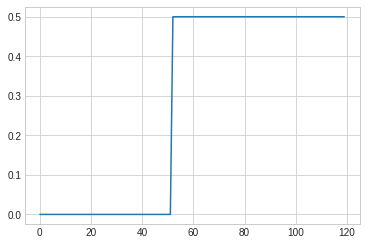

In [26]:
plt.plot(np.sort(impartial.step_weights(score_matrix, k, 0)))

In [43]:
from scipy.optimize import root_scalar

def prob_sample(n, m, x, r):

    t = scipy.special.comb(r-1, x-1, exact=True)*scipy.special.comb(n-r, m-x, exact=True)/scipy.special.comb(n-1, m-1, exact=True)

    return t

"Probability of being accepted by the algorithm given position r in the ranking."
def prob_acc(n, m, k, r, eps=0):
    quota = k*m/n + eps
    q = sum([prob_sample(n, m, i, r) for i in range(1, int(np.floor(quota))+1)]) + (quota-np.floor(quota))*prob_sample(n, m, np.floor(quota)+1, r)
    return sum([scipy.special.comb(m, i)*(q**i)*(1-q)**(m-i) for i in range(int(np.ceil(m/2)), m+1)])

"Expected accuracy of the algorithm."
# exp_acc(n, m, k, eps=0) = sum([prob_acc(n, m, k, r, eps) for r in 1:k])/k
def exp_size(n, m, k, eps=0):
    return sum([prob_acc(n, m, k, r, eps) for r in range(1, n+1)])

# "Varance of true positives."
# exp_tp(n, m, k, eps=0) = sum([prob_acc(n, m, k, r, eps) for r in 1:k])
# var_tp(n, m, k, eps=0) = sum([prob_acc(n, m, k, r, eps)*(1-prob_acc(n, m, k, r, eps)) for r in 1:k])

"Estimate epsilon given n, m, k to produce the correct expected size."
def estimate_eps(n, m, k):
    f = lambda x : exp_size(n, m, k, x) - k
    return root_scalar(f, bracket=[-1,1]).root


In [49]:
estimate_eps(120, 7, 20) - Main.estimate_eps(120, 7, 20)

-1.3322676295501878e-15


---


In [213]:
n = 120
k = 25
m = 9
l = 4
p = 0.9

agents = np.arange(0, n)
profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [p, 1-p], [agents, agents[::-1]], [0.8, 0.8])
clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)

# Borda -- need to start at 1 to distinguish from non-review in the score matrix
scores = np.arange(m, 0, -1)

# Approval a-la PeerNomination
nom_quota = (k/n)*m
scores_pn = np.concatenate((np.ones(math.floor(nom_quota)),
        [nom_quota-math.floor(nom_quota)],
        np.zeros(m-math.ceil(nom_quota))))

# Generate an m-regular assignment
m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)

score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

In [21]:
for pool in (score_matrix[1, :]):
    print(pool)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [198]:
(1-np.ones(10)/8)**3

array([0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67])

In [12]:
score_matrix[1,:].nonzero()[0]

array([  7,  18,  36,  47,  58,  69,  81,  97, 110])

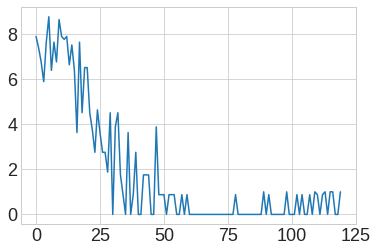

In [38]:
plt.plot([sum(impartial.nomination_scores(score_matrix, k, 0)[i, :]) for i in range(n)])

In [178]:
len(impartial.weighted_peer_nomination(score_matrix, k, None, Main.estimate_eps(n, m, k)))

25

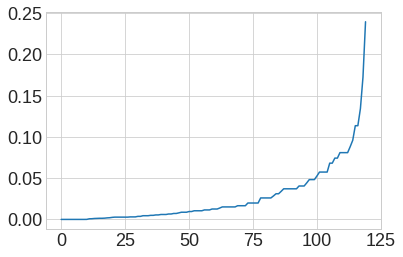

In [249]:
plt.plot(np.sort(impartial.dist_weights(score_matrix, k, epsilon=0, agg=25)))

---

In [11]:
_DEBUG = False

#random.seed(15)

s = 10
test_n = [120]
test_k = [20, 25, 30]
test_m = [7, 8, 9]
test_l = [2]
test_p = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1]

# Map for all Results.
gt_results = {}
pn_sizes = {}  #track output size of peer nomination
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    
    eps_estimate = Main.estimate_eps(n, m, k)
    
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [p, 1-p], [agents, agents], [0.5, 1])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Borda -- need to start at 1 to distinguish from non-review in the score matrix
        scores = np.arange(m, 0, -1)
        
        # Approval a-la PeerNomination
        nom_quota = (k/n)*m
        scores_pn = np.concatenate((np.ones(math.floor(nom_quota)),
                [nom_quota-math.floor(nom_quota)],
                np.zeros(m-math.ceil(nom_quota))))
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)
        
        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)
        score_matrix_pn = profile_generator.strict_m_score_matrix(profile, m_assignment, scores_pn)
        
        # Capture the winning sets
        ws = {}

        # Run peer nomination using the estimated epsilon
        ws[Impartial.NOMINATION] = impartial.peer_nomination_lottery(score_matrix, k, eps_estimate)
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws["EDP_rank"] = impartial.exact_dollar_partition_explicit(score_matrix_pn, k, clustering, normalize=True)
        ws["PN_dist"] = impartial.weighted_peer_nomination(score_matrix, k, impartial.dist_weights, eps_estimate)
        ws["PN_maj"] = impartial.weighted_peer_nomination(score_matrix, k, impartial.maj_weights, eps_estimate)
        ws["PN_step"] = impartial.weighted_peer_nomination(score_matrix, k, impartial.step_weights, eps_estimate)


        for x in [Impartial.NOMINATION, Impartial.EXACT, "EDP_rank", "PN_dist", "PN_maj", "PN_step"]:
            key = (n, k, m, l, p, s, x)
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            pn_sizes[key] = pn_sizes.get(key, []) + [len(set(ws[x]))]

            
        key = (n, k, m, l, p)
        
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
print("All done!")

df = pd.DataFrame(gt_results)
df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']


Didn't get a distribution on allocation.  Allocated 0.0, should be near 1.0.


NameError: name 'exit' is not defined

In [8]:
df.to_pickle("db/edp_vs_peer_adv.pkl")

In [18]:
df1 = pd.read_pickle("db/edp_vs_peer_adv.pkl")

In [262]:
df.to_pickle("db/edp_vs_weightedPN_random.pkl")

In [252]:
pn_sizes_dist_adv 

{(120, 20, 7, 4, 0.1, 100, 'PeerNomination'): [16,
  20,
  19,
  18,
  17,
  19,
  17,
  23,
  20,
  21,
  19,
  16,
  17,
  18,
  16,
  19,
  22,
  18,
  16,
  21,
  20,
  16,
  21,
  19,
  18,
  13,
  19,
  18,
  14,
  15,
  16,
  20,
  21,
  22,
  20,
  20,
  21,
  21,
  18,
  16,
  18,
  19,
  17,
  15,
  23,
  17,
  16,
  18,
  20,
  20,
  15,
  15,
  15,
  19,
  16,
  17,
  17,
  18,
  17,
  19,
  17,
  20,
  17,
  19,
  17,
  16,
  16,
  17,
  19,
  16,
  20,
  19,
  16,
  19,
  18,
  20,
  17,
  17,
  17,
  21,
  18,
  21,
  16,
  15,
  16,
  15,
  17,
  17,
  19,
  17,
  22,
  14,
  17,
  17,
  17,
  17,
  20,
  18,
  17,
  19],
 (120, 20, 7, 4, 0.1, 100, 'ExactDollarPartition'): [20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  2

In [248]:
df_dist_adv

n               120                                              \
k                20                                               
m                 7                                               
l                 4                                               
p              0.10                                               
s               100                                               
algo PeerNomination ExactDollarPartition EDP_rank peer_weighted   
0                 0                    0        0             0   
1                 0                    0        1             0   
2                 0                    0        0             0   
3                 0                    0        0             0   
4                 0                    0        0             0   
..              ...                  ...      ...           ...   
95                0                    0        0             0   
96                0                    0        0             0   
97                0                    0        0             0   
98                0                    0        0             0   
99                0                    0        1             0   

n                                                                \
k                                                                 
m                                                                 
l                                                                 
p              0.25                                               
s               100                                               
algo PeerNomination ExactDollarPartition EDP_rank peer_weighted   
0                 1                    0        4             2   
1                 3                    1        5             4   
2                 0                    0        4             0   
3                 1                    0        2             1   
4                 0                    0        1             0   
..              ...                  ...      ...           ...   
95                2                    1        3             5   
96                0                    0        3             1   
97                1                    0        1             1   
98                0                    0        2             2   
99                0                    0        1             0   

n                                         ...                         \
k                                         ...       30                 
m                                         ...        9                 
l                                         ...        4                 
p              0.50                       ...     0.50                 
s               100                       ...      100                 
algo PeerNomination ExactDollarPartition  ... EDP_rank peer_weighted   
0                 6                    8  ...       15            15   
1                 3                    4  ...       10             9   
2                 3                    2  ...       14             9   
3                 1                    3  ...       15            13   
4                 6                    6  ...       12             6   
..              ...                  ...  ...      ...           ...   
95                6                    9  ...       13            11   
96                3                    3  ...       11             6   
97                4                    4  ...       15            14   
98                4                    5  ...       13            12   
99                4                    2  ...       16            17   

n                                                                \
k                                                                 
m                                                                 
l                                                                 
p              0.75  

In [87]:
df = pd.read_pickle("../experiments/some_test.pkl")

In [88]:
{x[:5] for x in df.columns}

{(120, 20, 7, 4, 0.1),
 (120, 20, 7, 4, 0.2),
 (120, 20, 7, 4, 0.3),
 (120, 20, 7, 4, 0.4),
 (120, 20, 7, 4, 0.5),
 (120, 20, 7, 4, 0.6),
 (120, 20, 7, 4, 0.7),
 (120, 20, 7, 4, 0.8),
 (120, 20, 7, 4, 0.9),
 (120, 20, 7, 4, 1.0),
 (120, 20, 8, 4, 0.1),
 (120, 20, 8, 4, 0.2),
 (120, 20, 8, 4, 0.3),
 (120, 20, 8, 4, 0.4),
 (120, 20, 8, 4, 0.5),
 (120, 20, 8, 4, 0.6),
 (120, 20, 8, 4, 0.7),
 (120, 20, 8, 4, 0.8),
 (120, 20, 8, 4, 0.9),
 (120, 20, 8, 4, 1.0),
 (120, 20, 9, 4, 0.1),
 (120, 20, 9, 4, 0.2),
 (120, 20, 9, 4, 0.3),
 (120, 20, 9, 4, 0.4),
 (120, 20, 9, 4, 0.5),
 (120, 20, 9, 4, 0.6),
 (120, 20, 9, 4, 0.7),
 (120, 20, 9, 4, 0.8),
 (120, 20, 9, 4, 0.9),
 (120, 20, 9, 4, 1.0),
 (120, 25, 7, 4, 0.1),
 (120, 25, 7, 4, 0.2),
 (120, 25, 7, 4, 0.3),
 (120, 25, 7, 4, 0.4),
 (120, 25, 7, 4, 0.5),
 (120, 25, 7, 4, 0.6),
 (120, 25, 7, 4, 0.7),
 (120, 25, 7, 4, 0.8),
 (120, 25, 7, 4, 0.9),
 (120, 25, 7, 4, 1.0),
 (120, 25, 8, 4, 0.1),
 (120, 25, 8, 4, 0.2),
 (120, 25, 8, 4, 0.3),
 (120, 25, 

In [21]:
df1.columns

MultiIndex([(120, 20, 7, 4, 0.1, 50,       'PeerNomination'),
            (120, 20, 7, 4, 0.1, 50, 'ExactDollarPartition'),
            (120, 20, 7, 4, 0.1, 50,             'EDP_rank'),
            (120, 20, 7, 4, 0.1, 50,              'PN_dist'),
            (120, 20, 7, 4, 0.1, 50,               'PN_maj'),
            (120, 20, 7, 4, 0.1, 50,              'PN_step'),
            (120, 20, 7, 4, 0.2, 50,       'PeerNomination'),
            (120, 20, 7, 4, 0.2, 50, 'ExactDollarPartition'),
            (120, 20, 7, 4, 0.2, 50,             'EDP_rank'),
            (120, 20, 7, 4, 0.2, 50,              'PN_dist'),
            ...
            (120, 30, 9, 4, 0.9, 50,             'EDP_rank'),
            (120, 30, 9, 4, 0.9, 50,              'PN_dist'),
            (120, 30, 9, 4, 0.9, 50,               'PN_maj'),
            (120, 30, 9, 4, 0.9, 50,              'PN_step'),
            (120, 30, 9, 4, 1.0, 50,       'PeerNomination'),
            (120, 30, 9, 4, 1.0, 50, 'ExactDollarParti

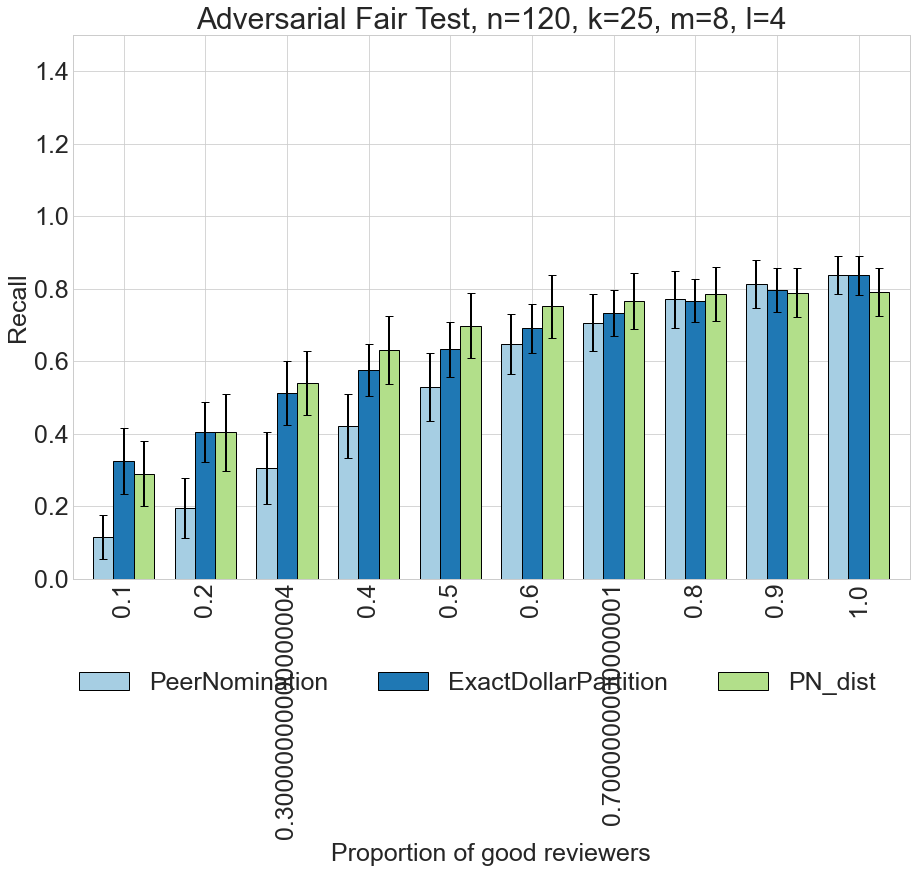

algo                PeerNomination  ExactDollarPartition  PN_dist
n   k  m l p   s                                                 
120 25 8 4 0.1 100          0.1156                0.3240   0.2888
           0.2 100          0.1952                0.4052   0.4032
           0.3 100          0.3048                0.5128   0.5396
           0.4 100          0.4220                0.5752   0.6304
           0.5 100          0.5284                0.6328   0.6980
           0.6 100          0.6476                0.6900   0.7516
           0.7 100          0.7060                0.7328   0.7668
           0.8 100          0.7708                0.7664   0.7860
           0.9 100          0.8132                0.7968   0.7892
           1.0 100          0.8388                0.8364   0.7912


In [97]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels, save=False):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    # print(means)
    # print(errors)
    algo_list = [Impartial.NOMINATION, Impartial.EXACT, "PN_dist"]
#     print("\t\tApproximate Vanilla Ordering")
#     means = means[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
#     errors = errors[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    # Uncomment to only compare PN and EDP
    means = means[algo_list]
    errors = errors[algo_list]
    
#     means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
#     errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
#     mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
#     print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     del means['PercentChange']
#     del errors['PercentChange']
#     del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.loc[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.loc[index] = row / float(index[1])
    
    # print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 10))
    color_list = color_list[:7]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(15, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75, edgecolor="k")
    plt.title(f"Adversarial Fair Test, n={test[0]}, k={test[1]}, m={test[2]}, l={test[3]}")
    plt.legend(bbox_to_anchor = (0,-0.05,1,1), bbox_transform=plt.gcf().transFigure, loc='lower center', ncol=7, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
#     plt.gca().set_xticks(fontsize=14)
#     plt.gca().set_yticks(fontsize=14)
#     plt.gca().set_xlabel("Number of clusters")
    plt.ylabel("Recall")
    plt.gca().set_xlabel("Proportion of good reviewers")
    plt.ylim([0, 1.5])
    if save:
        plt.savefig(f"figs/weighted_vs_edp_fair_k{test[1]}m{test[2]}.png", bbox_inches="tight")    
    plt.show()
    print(means)
make_output(df, (120, 25, 8, 4, slice(None), 100), np.arange(0.1, 1.1, 0.1))


In [95]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

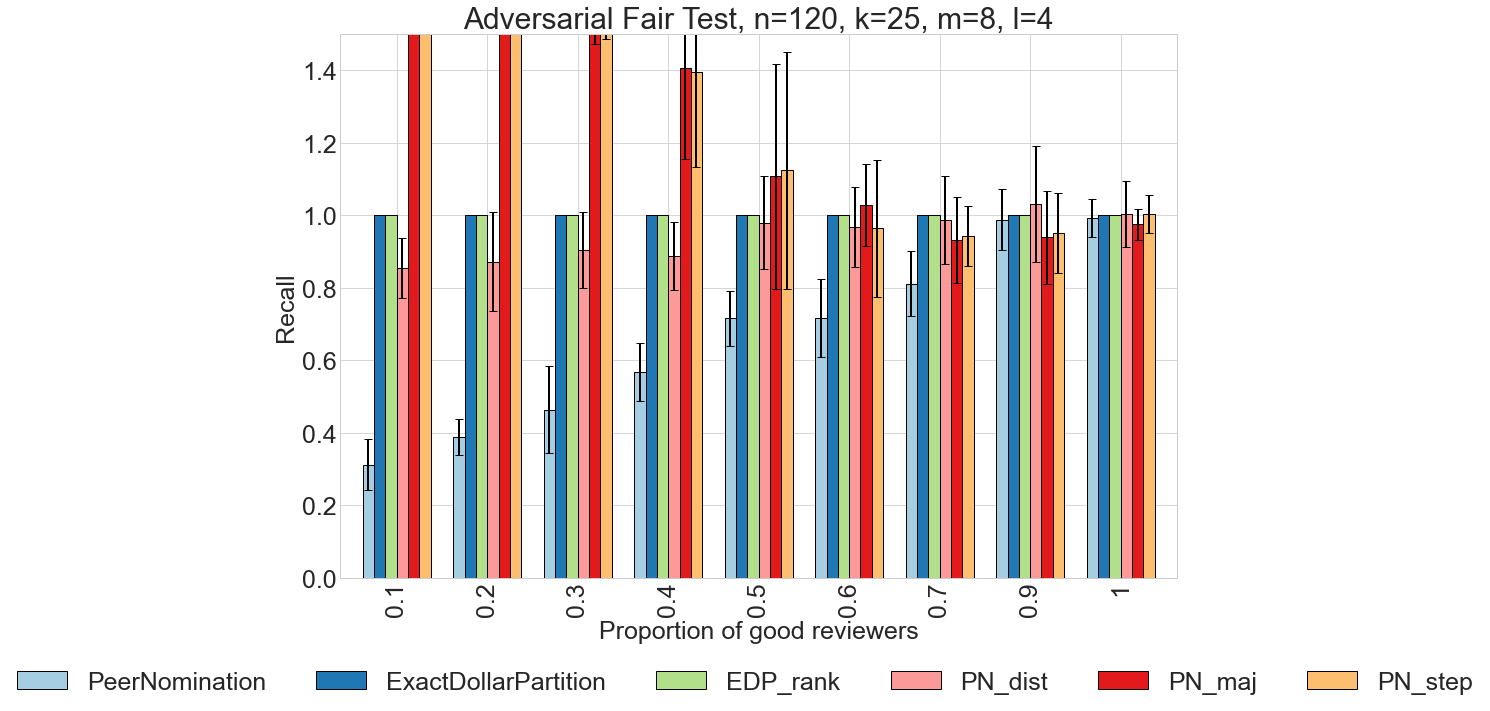

                   PeerNomination  ExactDollarPartition  EDP_rank  PN_dist  \
120 25 8 4 0.1 10           0.312                   1.0       1.0    0.856   
           0.2 10           0.388                   1.0       1.0    0.872   
           0.3 10           0.464                   1.0       1.0    0.904   
           0.4 10           0.568                   1.0       1.0    0.888   
           0.5 10           0.716                   1.0       1.0    0.980   
           0.6 10           0.716                   1.0       1.0    0.968   
           0.7 10           0.812                   1.0       1.0    0.988   
           0.9 10           0.988                   1.0       1.0    1.032   
           1.0 10           0.992                   1.0       1.0    1.004   

                   PN_maj  PN_step  
120 25 8 4 0.1 10   3.020    3.004  
           0.2 10   2.416    2.412  
           0.3 10   1.880    1.864  
           0.4 10   1.408    1.396  
           0.5 10   1.108    1.124

In [10]:
make_output(pd.DataFrame(pn_sizes), (120, 25, 8, 4, slice(None), s), test_p)


## Fair Test 

In [12]:
_DEBUG = False

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    WEIGHTED = "PeerWeighted"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

s = 1000
test_n = [120]
test_k = [20, 25, 30]
test_m = [5, 7, 9]
test_l = [4]
test_p = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Map for all Results.
v_results = {}
gt_results = {}
pn_sizes = {}  #track output size of peer nomination
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    eps_estimate = Main.estimate_eps(n, m, k)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [p, 1-p], [agents, agents[::-1]], [0.8, 0.8])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Borda -- need to start at 1 to distinguish from non-review in the score matrix
        scores = np.arange(m, 0, -1)
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)

        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
        # Run peer nomination using the estimated epsilon
        ws[Impartial.WEIGHTED] = impartial.weighted_peer_nomination(score_matrix, k, impartial.dist_weights, eps_estimate)
        size = len(set(ws[Impartial.WEIGHTED]))
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, size, clustering, normalize=True)

        
        for x in [Impartial.WEIGHTED, Impartial.EXACT]:
            key = (n, k, m, l, p, s, x)
#             v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            pn_sizes[key] = pn_sizes.get(key, []) + [size]
        
#     print("k = " + str(k) + ", actual average size = " + str(np.mean(pn_sizes[key])))
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
print("All done!")
    
# v_df_2 = pd.DataFrame(v_results)
# v_df_2.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# gt_df_2 = pd.DataFrame(gt_results)
# gt_df_2.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

fair_df = pd.DataFrame(gt_results)
fair_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# cluster2_df = pd.DataFrame(gt_results)
# cluster2_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']


Finished: 120,20,5,4,0.5,1000
Finished: 120,20,5,4,0.6,1000
Finished: 120,20,5,4,0.7,1000
Finished: 120,20,5,4,0.8,1000
Finished: 120,20,5,4,0.9,1000
Finished: 120,20,5,4,1,1000
Finished: 120,20,7,4,0.5,1000
Finished: 120,20,7,4,0.6,1000
Finished: 120,20,7,4,0.7,1000
Finished: 120,20,7,4,0.8,1000
Finished: 120,20,7,4,0.9,1000
Finished: 120,20,7,4,1,1000
Finished: 120,20,9,4,0.5,1000
Finished: 120,20,9,4,0.6,1000
Finished: 120,20,9,4,0.7,1000
Finished: 120,20,9,4,0.8,1000
Finished: 120,20,9,4,0.9,1000
Finished: 120,20,9,4,1,1000
Finished: 120,25,5,4,0.5,1000
Finished: 120,25,5,4,0.6,1000
Finished: 120,25,5,4,0.7,1000
Finished: 120,25,5,4,0.8,1000
Finished: 120,25,5,4,0.9,1000
Finished: 120,25,5,4,1,1000
Finished: 120,25,7,4,0.5,1000
Finished: 120,25,7,4,0.6,1000
Finished: 120,25,7,4,0.7,1000
Finished: 120,25,7,4,0.8,1000
Finished: 120,25,7,4,0.9,1000
Finished: 120,25,7,4,1,1000
Finished: 120,25,9,4,0.5,1000
Finished: 120,25,9,4,0.6,1000
Finished: 120,25,9,4,0.7,1000
Finished: 120,25,9,4

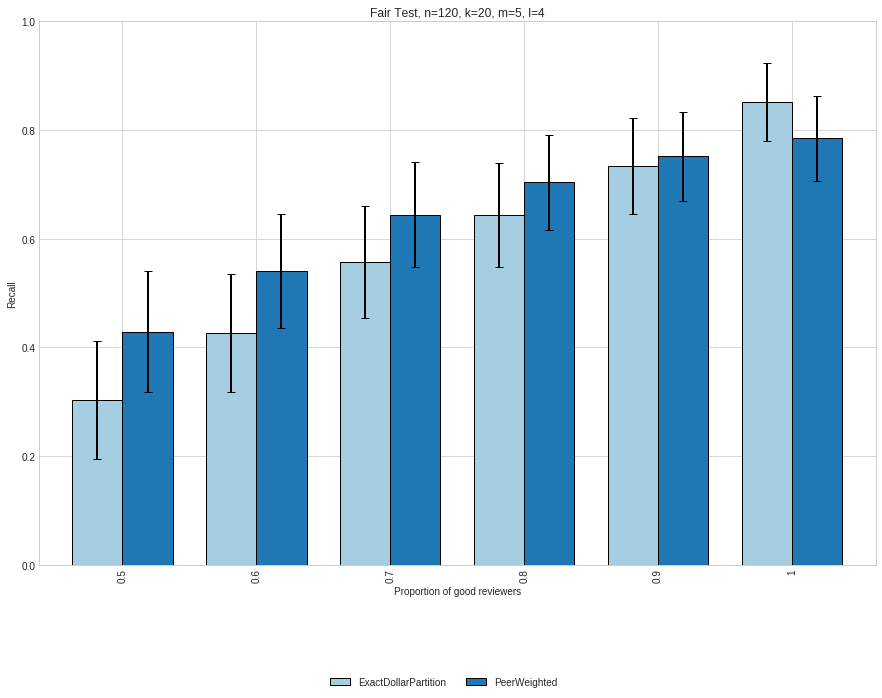

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 20 5 4 0.5 1000               0.30300       0.42870
           0.6 1000               0.42620       0.54060
           0.7 1000               0.55660       0.64410
           0.8 1000               0.64405       0.70405
           0.9 1000               0.73385       0.75125
           1.0 1000               0.85150       0.78440


In [28]:
test_n = [120]
test_k = [20, 25, 30]
test_m = [5, 7, 9]
test_l = [4]
test_p = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
make_output(fair_df, (120, 20, 5, 4, slice(None)), test_p)

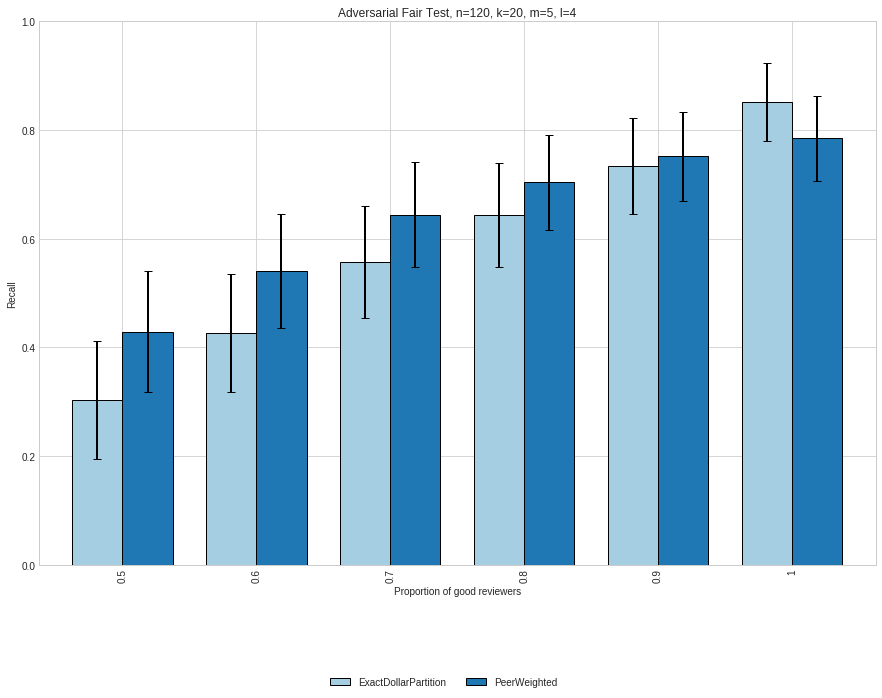

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 20 5 4 0.5 1000               0.30300       0.42870
           0.6 1000               0.42620       0.54060
           0.7 1000               0.55660       0.64410
           0.8 1000               0.64405       0.70405
           0.9 1000               0.73385       0.75125
           1.0 1000               0.85150       0.78440


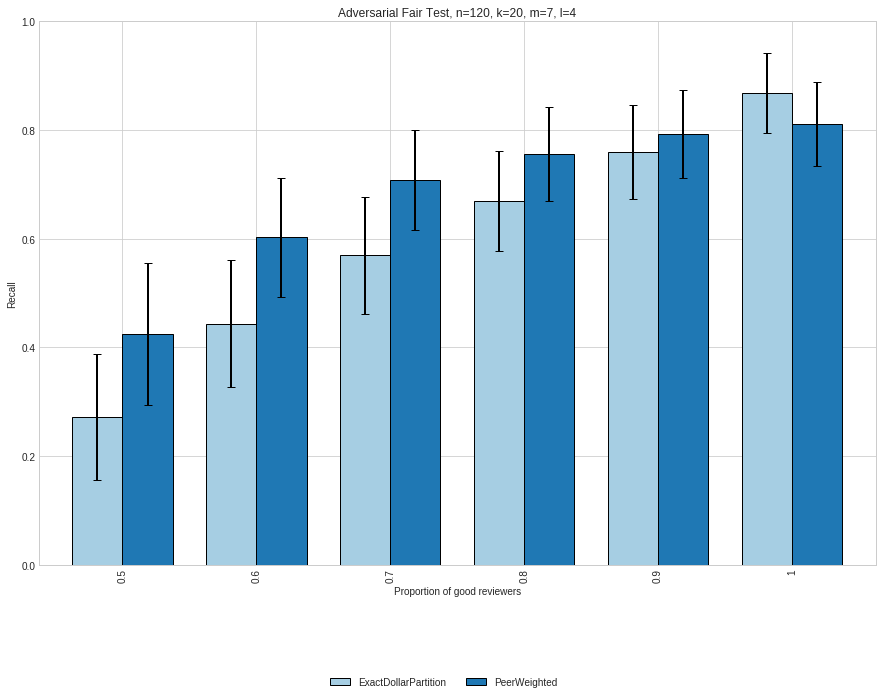

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 20 7 4 0.5 1000               0.27195       0.42440
           0.6 1000               0.44380       0.60215
           0.7 1000               0.56915       0.70850
           0.8 1000               0.66960       0.75610
           0.9 1000               0.75960       0.79260
           1.0 1000               0.86735       0.81145


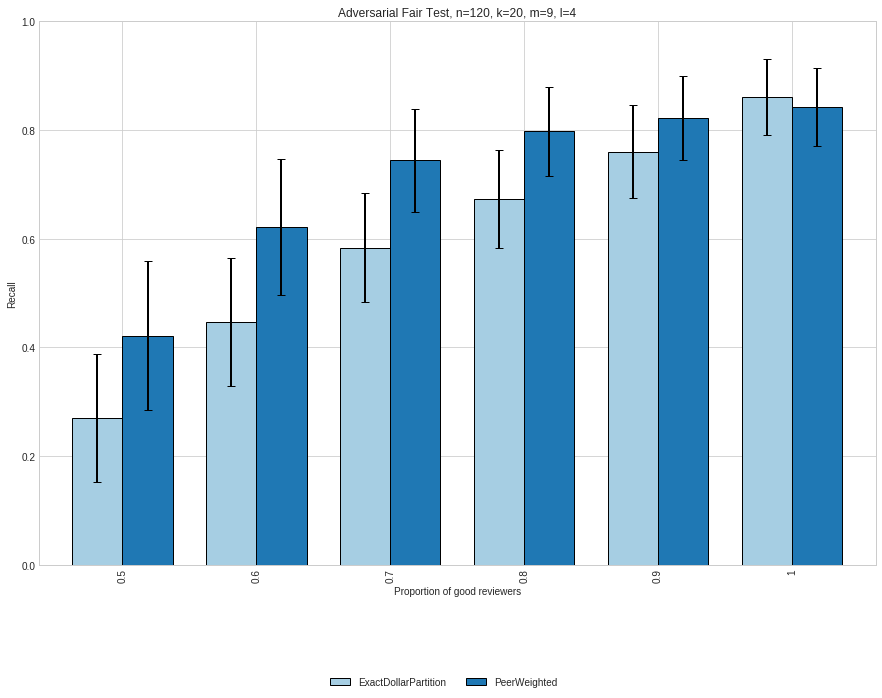

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 20 9 4 0.5 1000               0.27000       0.42170
           0.6 1000               0.44670       0.62190
           0.7 1000               0.58335       0.74390
           0.8 1000               0.67245       0.79730
           0.9 1000               0.75990       0.82135
           1.0 1000               0.86000       0.84300


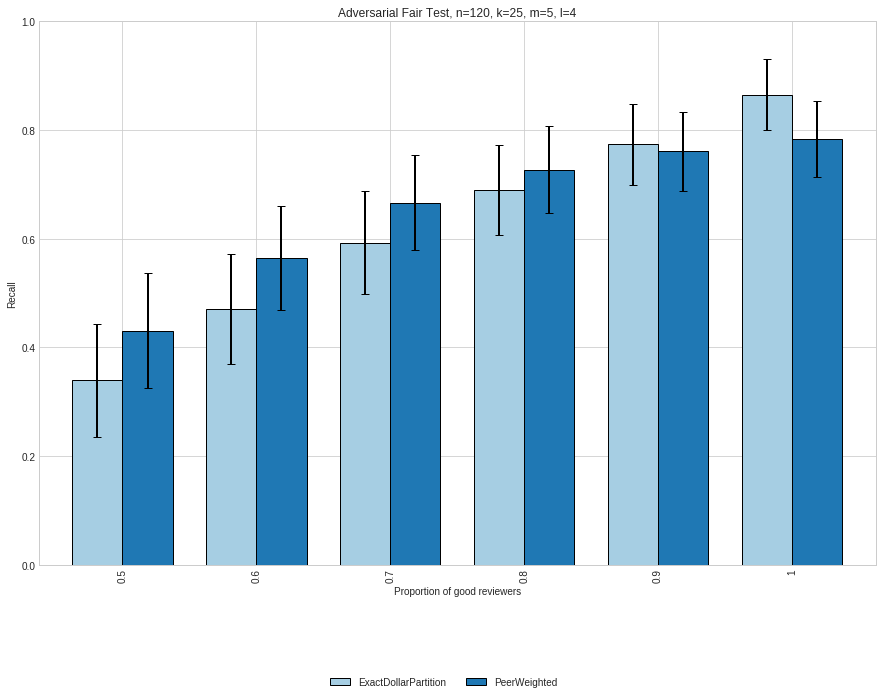

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 25 5 4 0.5 1000               0.33932       0.43076
           0.6 1000               0.47096       0.56424
           0.7 1000               0.59264       0.66608
           0.8 1000               0.68968       0.72708
           0.9 1000               0.77336       0.76040
           1.0 1000               0.86504       0.78260


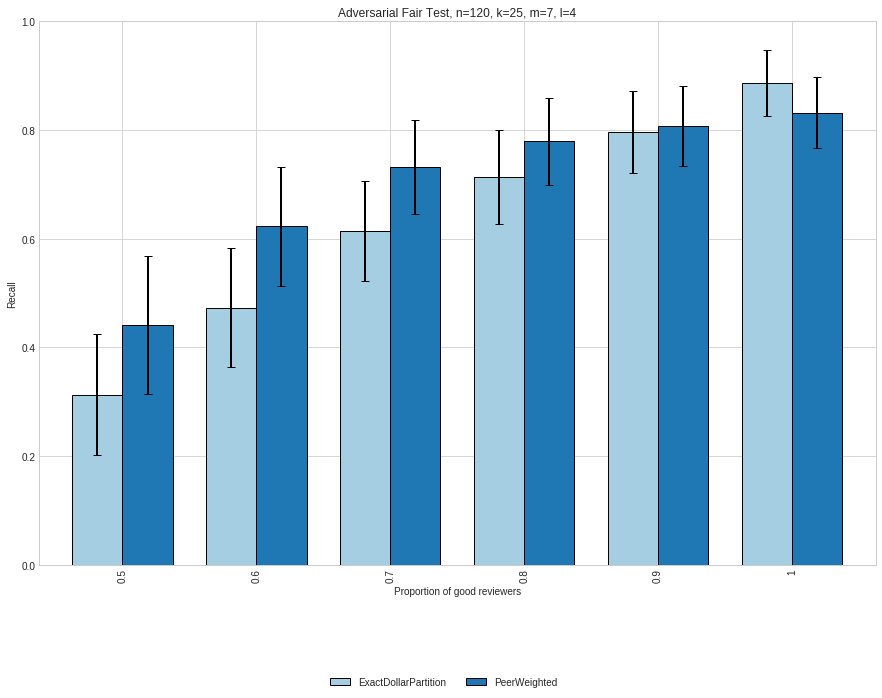

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 25 7 4 0.5 1000               0.31324       0.44124
           0.6 1000               0.47328       0.62252
           0.7 1000               0.61428       0.73180
           0.8 1000               0.71352       0.77896
           0.9 1000               0.79584       0.80720
           1.0 1000               0.88632       0.83196


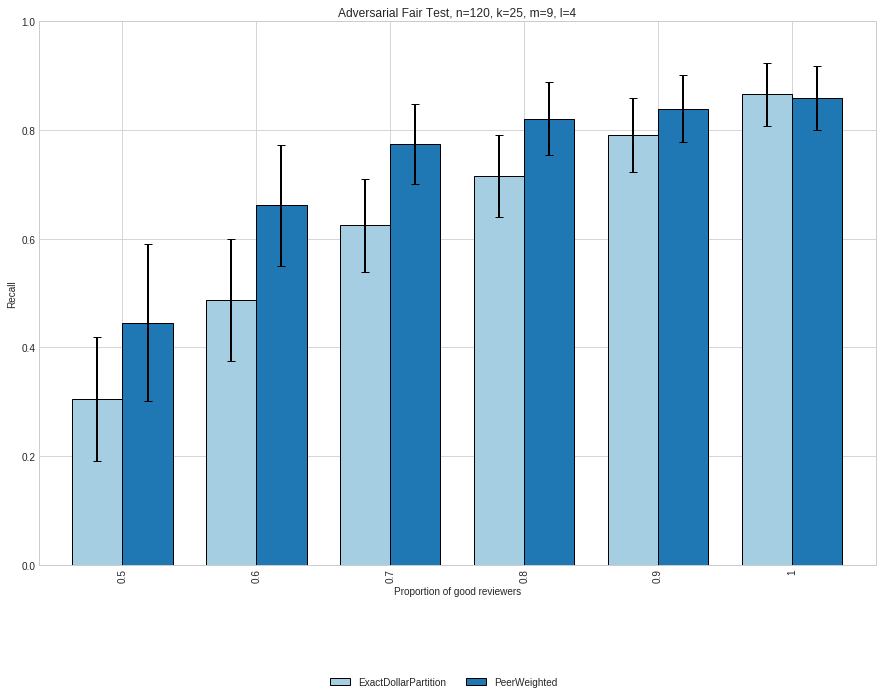

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 25 9 4 0.5 1000               0.30468       0.44508
           0.6 1000               0.48684       0.66112
           0.7 1000               0.62492       0.77408
           0.8 1000               0.71536       0.82064
           0.9 1000               0.79072       0.83928
           1.0 1000               0.86532       0.85828


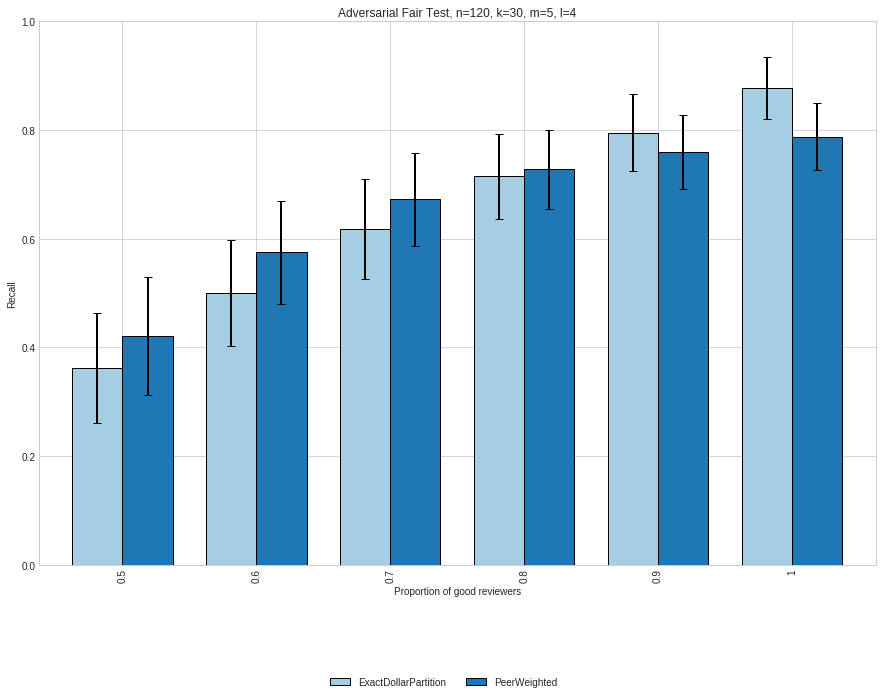

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 30 5 4 0.5 1000              0.361733      0.421200
           0.6 1000              0.500733      0.574633
           0.7 1000              0.618267      0.672167
           0.8 1000              0.714367      0.727867
           0.9 1000              0.795167      0.758900
           1.0 1000              0.877167      0.787633


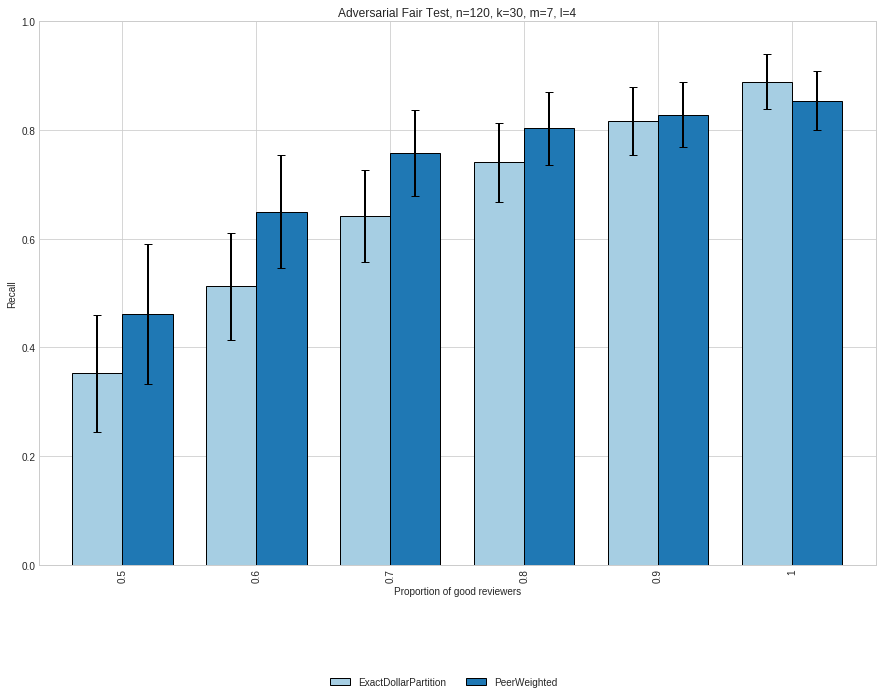

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 30 7 4 0.5 1000              0.351933      0.461400
           0.6 1000              0.512233      0.649700
           0.7 1000              0.641400      0.757200
           0.8 1000              0.740133      0.802667
           0.9 1000              0.816733      0.828000
           1.0 1000              0.888933      0.853367


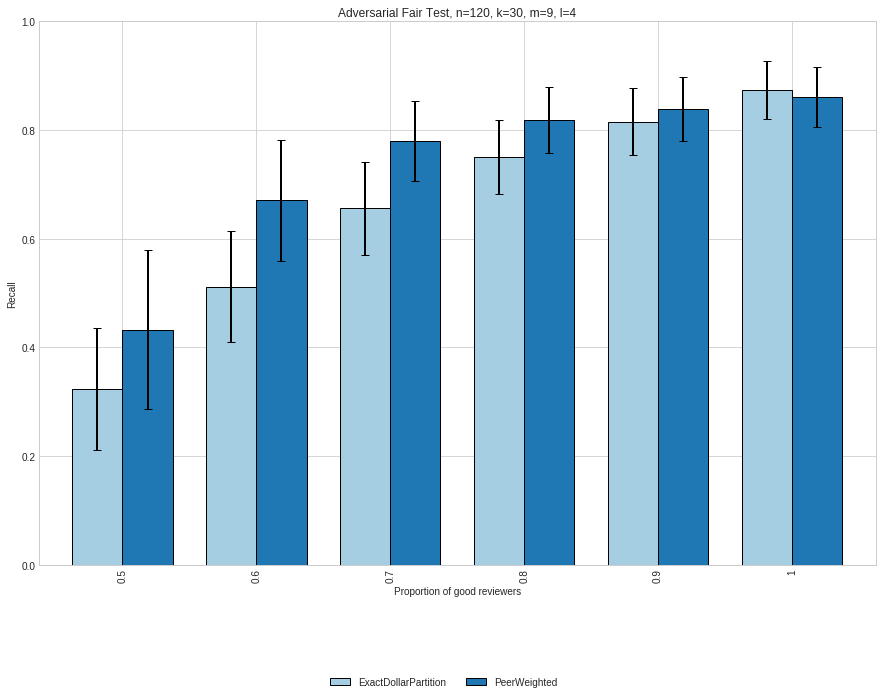

algo                 ExactDollarPartition  PeerWeighted
n   k  m l p   s                                       
120 30 9 4 0.5 1000              0.323533      0.432500
           0.6 1000              0.511467      0.670567
           0.7 1000              0.655467      0.779500
           0.8 1000              0.750000      0.818500
           0.9 1000              0.815267      0.838500
           1.0 1000              0.873333      0.860100


In [31]:
for n,k,m,l in itertools.product(test_n, test_k, test_m, test_l):
    make_output(fair_df, (n, k, m, l, slice(None)), test_p, save=True)
# plt.savefig("figs/weighted_fair.png")

In [56]:
fair_df.to_pickle("db/weighted_fair_random.pkl")

In [183]:
data = gt_df.join(gt_df_2)

In [189]:
data_v = v_df.join(v_df_2)

In [188]:
data.to_pickle("db/final.pkl")

In [190]:
data_v.to_pickle("db/final_v.pkl")

In [191]:
data_v

n        120                                                             \
k         15                                                              
m          7                                                              
l          4                                                              
p        0.5                                                              
s        100                                                              
algo Vanilla ExactDollarPartition Partition DollarRaffle CredibleSubset   
0         15                   13        13            1             15   
1         15                   13        13            6             15   
2         15                   12        13            5             15   
3         15                   11        11            5             15   
4         15                   13        12            6             15   
5         15                   14        14            3              0   
6         15                   10         9            1             15   
7         15                   13        12            5             15   
8         15                   13        13            2             15   
9         15                   14        13            2             15   
10        15                   11        12            3              0   
11        15                   15        15            6             15   
12        15                   12        12            3             15   
13        15                   10        10            1             15   
14        15                   13        13            1              0   
15        15                   12        12            3             15   
16        15                   12        13            2             15   
17        15                   14        13            2              0   
18        15                   10        11            2             15   
19        15                   14        14            0              0   
20        15                   14        14            2              0   
21        15                   12        12            5              0   
22        15                   12        11            4             15   
23        15                   13        12            2             15   
24        15                   11        12            2              0   
25        15                   12        12            4             15   
26        15                   14        13            6             15   
27        15                   12        12            3              0   
28        15                   13        13            3             15   
29        15                   14        14            6             15   
..       ...                  ...       ...          ...            ...   
70        15                   13        12            4              0   
71        15                   12        14            5              0   
72        15                   10        11            3              0   
73        15                   12        12            2             15   
74        15                   13        14            5             15   
75        15                   11        11            2              0   
76        15                   12        12            3             15   
77        15                   12        13            3              0   
78        15                   12        13            7              0   
79        15                   13        12            4             15   
80        15                   14        14            3             15   
81        15                   13        12            3              0   
82        15                   13        13            3              0   
83        15                   12        11            4             15   
84        15                   10        10            3             15   
85        15             

In [14]:
_DEBUG = False

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

s = 1000
test_n = [120]
test_k = [30]
test_m = [13, 15]
test_l = [4]
test_p = [0.5]

# Map for all Results.
v_results = {}
gt_results = {}
# pn_sizes = {}  #track output size of peer nomination
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Borda -- need to start at 1 to distinguish from non-review in the score matrix
        scores = np.arange(m, 0, -1)
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)

        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
#         # Set all sizes to be the same.
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        # Run peer nomination using the estimated epsilon
        ws[Impartial.NOMINATION] = impartial.peer_nomination_lottery(score_matrix, k, Main.estimate_eps(n, m, k))
        size = len(set(ws[Impartial.NOMINATION]))
#         ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, size, clustering, normalize=True)

        
        for x in Impartial.ALL:
            key = (n, k, m, l, p, s, x)
            v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            
        key = (n, k, m, l, p)
        pn_sizes[key] = pn_sizes.get(key, []) + [size]
        
    print("k = " + str(k) + ", actual average size = " + str(np.mean(pn_sizes[key])))
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
print("All done!")
    
v_df_4 = pd.DataFrame(v_results)
v_df_4.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df_4 = pd.DataFrame(gt_results)
gt_df_4.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# fair_df = pd.DataFrame(gt_results)
# fair_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# cluster2_df = pd.DataFrame(gt_results)
# cluster2_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']


k = 30, actual average size = 30.354
Finished: 120,30,13,4,0.5,1000
k = 30, actual average size = 30.622
Finished: 120,30,15,4,0.5,1000
All done!


In [34]:
gt_df_3.join(gt_df_4).to_pickle("db/final3.pkl")
v_df_3.join(v_df_4).to_pickle("db/final_v3.pkl")

In [129]:
v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

In [11]:
gt_df_3.to_pickle("db/final2.pkl")
v_df_3.to_pickle("db/final_v2.pkl")

([<matplotlib.axis.XTick at 0x7f3be74158d0>,
 <a list of 9 Text xticklabel objects>)

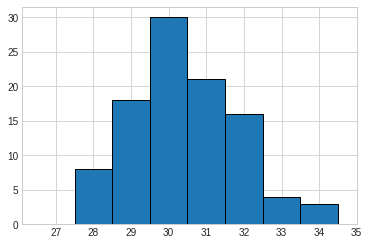

In [156]:
plt.hist(pn_sizes[(120,30,8,4,0.5)], bins=np.arange(27, 36), align="left", edgecolor="k")
plt.xticks(np.arange(27, 36))

In [92]:
len([x for x in pn_sizes[(120,25,10,5,0.0)] if x==27])


4

In [131]:
gt_df.to_pickle("db/gt_df2.pkl")
v_df.to_pickle("db/v_df2.pkl")

In [47]:
fair_df.to_pickle("db/fair_df1.pkl")

In [157]:
fair_df

n                     120                                                     \
k                      15                                                      
m                      8                                   9                   
l                       5                                   5                  
p                     0.0                                 0.0                  
s                      50                                  50                  
algo ExactDollarPartition PeerNomination ExactDollarPartition PeerNomination   
0                      12             12                   11             12   
1                      13             12                   11             13   
2                      12             15                   13             12   
3                      14             14                   11             12   
4                      10             10                   12             14   
5                       9             12                   11             12   
6                      13             15                   14             12   
7                      12             12                   13             12   
8                      11             12                   13             12   
9                      11             12                   12             13   
10                     10             12                   12             12   
11                     10             12                   12             12   
12                     13             14                   12             13   
13                      8             10                   12             12   
14                      8             10                   14             14   
15                     11             11                   13             12   
16                     13             14                   12             12   
17                     12             14                   13             12   
18                     11             13                   10             11   
19                     13             11                   12             14   
20                     10             13                   10             14   
21                     12             12                   11             12   
22                     11             13                   12             14   
23                     12             13                   12             14   
24                     10             11                   11             12   
25                     13             13                   10             10   
26                     13             12                   13             13   
27                     13             11                   11             11   
28                     14             13                   13             14   
29                      9             10                   10             11   
30                     11             13                   12             13   
31                      9             10                   13             12   
32                     12             13                   10             13   
33                     11             10                   14             13   
34                     10             13                   12             13   
35                     12             12                    9             10   
36                     12             12                   11             12   
37                     13             11                   13             13   
38                     12             13                   14             14   
39                      9             11                   10              9   
40                     10             12                   13             12   
41                     10             11                   12             12   
42                     12             14                   14             15   


In [39]:
matplotlib.rcParams.update({'font.size': 36})
# mpl.rcParams['xtick.labelsize'] = 26

		Approximate Vanilla Ordering


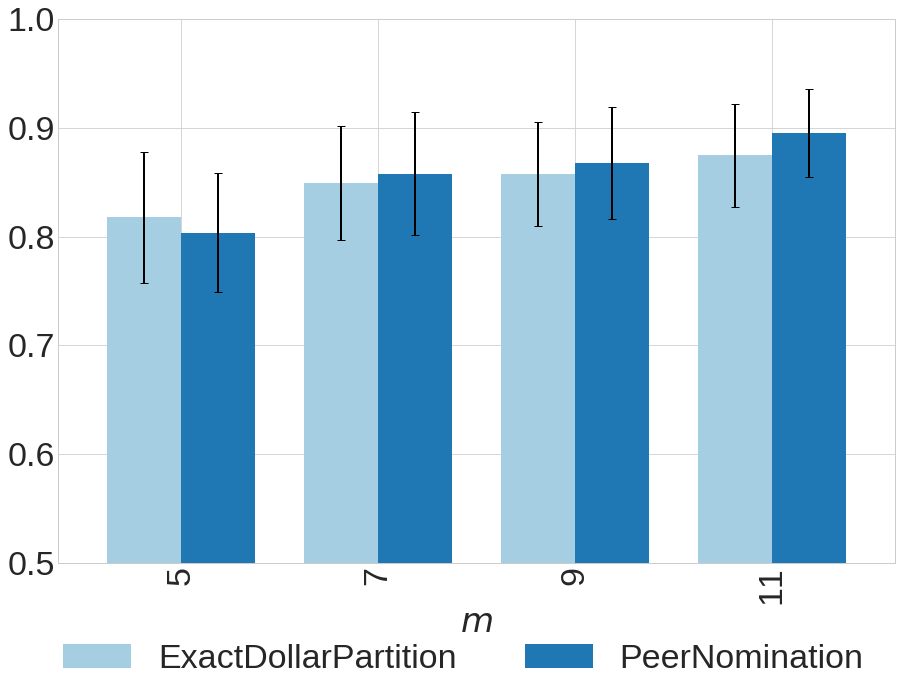

In [42]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    # print(means)
    # print(errors)

    print("\t\tApproximate Vanilla Ordering")
#     means = means[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
#     errors = errors[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    # Uncomment to only compare PN and EDP
    means = means[['ExactDollarPartition', "PeerNomination"]]
    errors = errors[['ExactDollarPartition', "PeerNomination"]]
    
#     means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
#     errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
#     mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
#     print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     del means['PercentChange']
#     del errors['PercentChange']
#     del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.loc[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.loc[index] = row / float(index[1])
    
    # print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 10))
    color_list = color_list[:7]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(15, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75)
#     plt.title("Fair Test")
    plt.legend(bbox_to_anchor = (0,-0.05,1,1), bbox_transform=plt.gcf().transFigure, loc='lower center', ncol=7, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
#     plt.gca().set_xticks(fontsize=14)
#     plt.gca().set_yticks(fontsize=14)
#     plt.gca().set_xlabel("Number of clusters")
    plt.gca().set_xlabel("$m$")
    plt.ylim([0.5, 1])
    plt.savefig("figs/figure5.png", bbox_inches="tight")
    plt.show()
make_output(fair_df2, (120,30,slice(None),4,0.5,100), test_m)

In [171]:
pn_sizes

{(120, 15, 5, 4, 0.5): [15,
  14,
  17,
  14,
  17,
  13,
  15,
  17,
  15,
  14,
  17,
  13,
  19,
  16,
  15,
  13,
  17,
  13,
  16,
  12,
  16,
  15,
  17,
  17,
  15,
  12,
  16,
  19,
  17,
  18,
  15,
  16,
  16,
  14,
  22,
  17,
  17,
  14,
  17,
  14,
  18,
  16,
  15,
  15,
  16,
  14,
  15,
  16,
  12,
  16,
  17,
  12,
  13,
  14,
  14,
  18,
  17,
  14,
  14,
  14,
  15,
  16,
  13,
  14,
  16,
  13,
  15,
  18,
  17,
  17,
  16,
  16,
  17,
  16,
  16,
  16,
  18,
  17,
  17,
  14,
  15,
  16,
  17,
  13,
  16,
  20,
  17,
  15,
  19,
  17,
  13,
  16,
  14,
  15,
  12,
  21,
  10,
  13,
  21,
  13],
 (120, 15, 6, 4, 0.5): [17,
  18,
  19,
  16,
  16,
  18,
  17,
  13,
  13,
  16,
  15,
  17,
  17,
  15,
  17,
  16,
  16,
  21,
  18,
  15,
  20,
  17,
  13,
  18,
  16,
  17,
  16,
  17,
  14,
  15,
  13,
  16,
  15,
  17,
  16,
  14,
  17,
  14,
  16,
  18,
  15,
  17,
  16,
  20,
  16,
  21,
  16,
  13,
  16,
  17,
  15,
  16,
  14,
  17,
  13,
  20,
  14,
  15,
  13,
 

In [167]:
rel_sizes = np.zeros((len(test_k), len(test_m)))
i = 0
j = 0
for k in test_k:
    for m in test_m:
#     print(np.mean(pn_sizes[(120,k,m,4,0.5)]))
        rel_sizes[i, j] = np.mean(pn_sizes[(120,k,m,4,0.5)])
        j += 1
    i =+ 1


IndexError: index 5 is out of bounds for axis 1 with size 5

In [165]:
rel_sizes

array([[35.01, 35.01, 35.01, 35.01, 35.01],
       [35.01, 35.01, 35.01, 35.01, 35.01],
       [35.01, 35.01, 35.01, 35.01, 35.01],
       [35.01, 35.01, 35.01, 35.01, 35.01],
       [35.01, 35.01, 35.01, 35.01, 35.01]])

In [140]:
pn_sizes

{(120, 15, 7, 4, 0.5): [16,
  16,
  15,
  16,
  16,
  16,
  15,
  17,
  19,
  15,
  15,
  17,
  17,
  16,
  13,
  15,
  14,
  16,
  17,
  13,
  16,
  14,
  16,
  15,
  14,
  17,
  17,
  18,
  14,
  16,
  19,
  14,
  15,
  17,
  16,
  17,
  15,
  16,
  16,
  16,
  15,
  15,
  12,
  16,
  15,
  15,
  12,
  15,
  16,
  15,
  18,
  14,
  14,
  17,
  17,
  17,
  14,
  13,
  16,
  15,
  17,
  14,
  13,
  16,
  15,
  15,
  17,
  16,
  15,
  16,
  15,
  14,
  16,
  19,
  15,
  15,
  16,
  16,
  14,
  18,
  16,
  15,
  15,
  15,
  15,
  15,
  13,
  14,
  15,
  14,
  17,
  15,
  14,
  15,
  14,
  14,
  15,
  16,
  12,
  17],
 (120, 15, 8, 4, 0.5): [18,
  17,
  16,
  16,
  14,
  14,
  17,
  15,
  14,
  15,
  16,
  15,
  14,
  18,
  14,
  14,
  15,
  17,
  18,
  15,
  17,
  17,
  16,
  15,
  15,
  16,
  15,
  18,
  17,
  15,
  17,
  12,
  13,
  14,
  13,
  17,
  18,
  15,
  14,
  18,
  14,
  15,
  18,
  15,
  12,
  15,
  16,
  16,
  14,
  13,
  15,
  16,
  15,
  15,
  14,
  17,
  17,
  16,
  17,
 

In [43]:
# Would be interesting to start with some distribution of valuations -
# EDP and such should be able to make use of more data
n = 130
k = 50
utilities = [1/(1+np.exp(0.1*(x-k))) for x in range(n)]

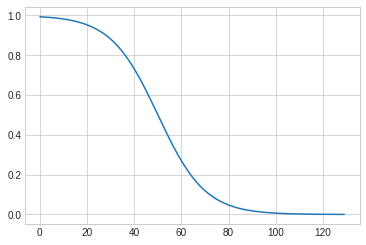

In [44]:
plt.plot(utilities)